# Introduction

**Problem Statement**

The purpose of project is to know people reaction based on sentiment about Sportify

# Import Libraries

In [ ]:
import tensorflow as tf
import keras
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
from sklearn.model_selection import train_test_split
from collections import Counter
from nltk.tokenize import sent_tokenize, word_tokenize
from wordcloud import WordCloud
from nltk.corpus import stopwords
from tensorflow.keras.layers import TextVectorization
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report
import pickle

In [2]:
# verify using GPU
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Data Loading

In [3]:
df = pd.read_csv('dataset.csv')

In [4]:
df.head()

Review     label
0  Great music service, the audio is high quality...  POSITIVE
1  Please ignore previous negative rating. This a...  POSITIVE
2  This pop-up "Get the best Spotify experience o...  NEGATIVE
3    Really buggy and terrible to use as of recently  NEGATIVE
4  Dear Spotify why do I get songs that I didn't ...  NEGATIVE

In [5]:
# check missing values
df.isnull().sum()

Review    16
label      0
dtype: int64

Terdapat 16 baris yang *missing values*. Dengan banyaknya data yang akan digunakan, maka jika hanya membuang 16 baris tidak akan memengaruhi **Modeling**.

In [6]:
# drop data yang barisnya ada missing values
df = df.dropna()

In [7]:
# check missing values after data cleaning
df.isnull().sum()

Review    0
label     0
dtype: int64

# Exploratory Data Analysis (Before Feature Engineering)

## Descriptive Statistics

### Data Distribution

In [8]:
eda = df.copy()

In [9]:
# check jumlah teks tiap label
print(eda['label'].value_counts())

label
NEGATIVE    29423
POSITIVE    23263
Name: count, dtype: int64


Data lumayan *balance* berdasarkan informasi diatas.

C:\Users\Rontlond\AppData\Local\Temp\ipykernel_6692\3976144188.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=eda, palette='winter', ax=ax[0])


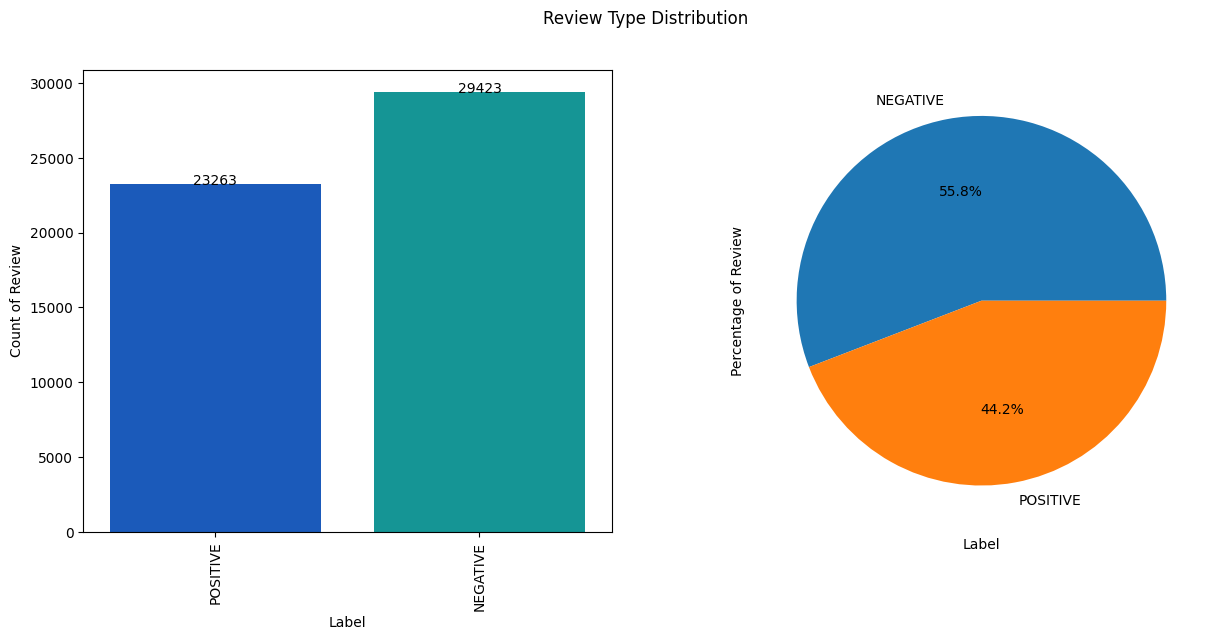

In [10]:
# Melihat secara garis besar persebaran data melalui visualisasi
fig, ax = plt.subplots(1,2,figsize=(15,6))

sns.countplot(x='label', data=eda, palette='winter', ax=ax[0])
ax[0].set_xlabel('Label')
ax[0].set_ylabel('Count of Review')
fig.suptitle('Review Type Distribution')
ax[0].tick_params(axis='x', rotation=90)
plt.xlabel('Label')
plt.ylabel('Count of Review')

for pch in ax[0].patches:
    ax[0].annotate('%.0f'%(pch.get_height()), (pch.get_x() + pch.get_width() / 2, pch.get_height()+205), ha='center', va='center')

eda['label'].value_counts().plot(kind='pie', autopct='%1.1f%%')
ax[1].set_ylabel('Percentage of Review')
plt.show()

### Sentence Analysis

In [11]:
# analisis banyaknya kalimat dalam sekali review
eda['len_sentence'] = eda['Review'].apply(lambda x: len(nltk.sent_tokenize(x)))
eda

Review     label  \
0      Great music service, the audio is high quality...  POSITIVE   
1      Please ignore previous negative rating. This a...  POSITIVE   
2      This pop-up "Get the best Spotify experience o...  NEGATIVE   
3        Really buggy and terrible to use as of recently  NEGATIVE   
4      Dear Spotify why do I get songs that I didn't ...  NEGATIVE   
...                                                  ...       ...   
52697                                       Yes the best  POSITIVE   
52698  Spotify won my heart in Feb 2024 You won my he...  POSITIVE   
52699  I tried to open the app and it wont open I res...  POSITIVE   
52700                                              Good   POSITIVE   
52701  Nice app to play music and at very affordable ...  POSITIVE   

       len_sentence  
0                 2  
1                 3  
2                 2  
3                 1  
4                 2  
...             ...  
52697             1  
52698             1  
52699             1  
52700             1  
52701             1  

[52686 rows x 3 columns]

In [12]:
print(f'Max kalimat pada review: {eda.len_sentence.max()}')
print(f'Mean kalimat pada review: {eda.len_sentence.mean()}')

Max kalimat pada review: 21
Mean kalimat pada review: 2.2111946247580003


In [13]:
rate1 = eda.label.unique()

for i in rate1:
    print(f'Label: {i}')
    print(f'Max kalimat pada tiap label: {eda[eda.label == i].len_sentence.max()}')
    print(f'Mean kalimat pada tiap label: {eda[eda.label == i].len_sentence.mean()}')
    print('-'*20)

Label: POSITIVE
Max kalimat pada tiap label: 16
Mean kalimat pada tiap label: 1.7154279327687745
--------------------
Label: NEGATIVE
Max kalimat pada tiap label: 21
Mean kalimat pada tiap label: 2.6031675899806275
--------------------


Berdasarkan informasi diatas, meskipun terdapat maksimal kalimat tiap *label* dalam sekali review sangat banyak, tetapi rata-rata sekitar 2 kalimat tiap review.

### Word Analysis

In [14]:
# analisis banyaknya kata dalam sekali review
eda['len_word'] = eda['Review'].apply(lambda x: len(nltk.word_tokenize(x)))
eda

Review     label  \
0      Great music service, the audio is high quality...  POSITIVE   
1      Please ignore previous negative rating. This a...  POSITIVE   
2      This pop-up "Get the best Spotify experience o...  NEGATIVE   
3        Really buggy and terrible to use as of recently  NEGATIVE   
4      Dear Spotify why do I get songs that I didn't ...  NEGATIVE   
...                                                  ...       ...   
52697                                       Yes the best  POSITIVE   
52698  Spotify won my heart in Feb 2024 You won my he...  POSITIVE   
52699  I tried to open the app and it wont open I res...  POSITIVE   
52700                                              Good   POSITIVE   
52701  Nice app to play music and at very affordable ...  POSITIVE   

       len_sentence  len_word  
0                 2        24  
1                 3        17  
2                 2        24  
3                 1         9  
4                 2        26  
...             ...       ...  
52697             1         3  
52698             1        58  
52699             1        54  
52700             1         1  
52701             1        10  

[52686 rows x 4 columns]

In [15]:
print(f'Max kata pada review: {eda.len_word.max()}')
print(f'Mean kata pada review: {eda.len_word.mean()}')

Max kata pada review: 424
Mean kata pada review: 32.2577155221501


In [16]:
rate2 = eda.label.unique()

for i in rate2:
    print(f'Label: {i}')
    print(f'Max kata pada tiap label: {eda[eda.label == i].len_word.max()}')
    print(f'Mean kata pada tiap label: {eda[eda.label == i].len_word.mean()}')
    print('-'*20)

Label: POSITIVE
Max kata pada tiap label: 334
Mean kata pada tiap label: 21.546103254094486
--------------------
Label: NEGATIVE
Max kata pada tiap label: 424
Mean kata pada tiap label: 40.726744383645446
--------------------


Berdasarkan informasi diatas, meskipun terdapat maksimal kata tiap *label* dalam sekali review sangat banyak, tetapi rata-rata tiap *label* berbeda:
- Pada *label* positif rata-ratanya yaitu 21 kata
- Pada *label* negatif rata-ratanya yaitu 40 kata

## Wordcloud

### General

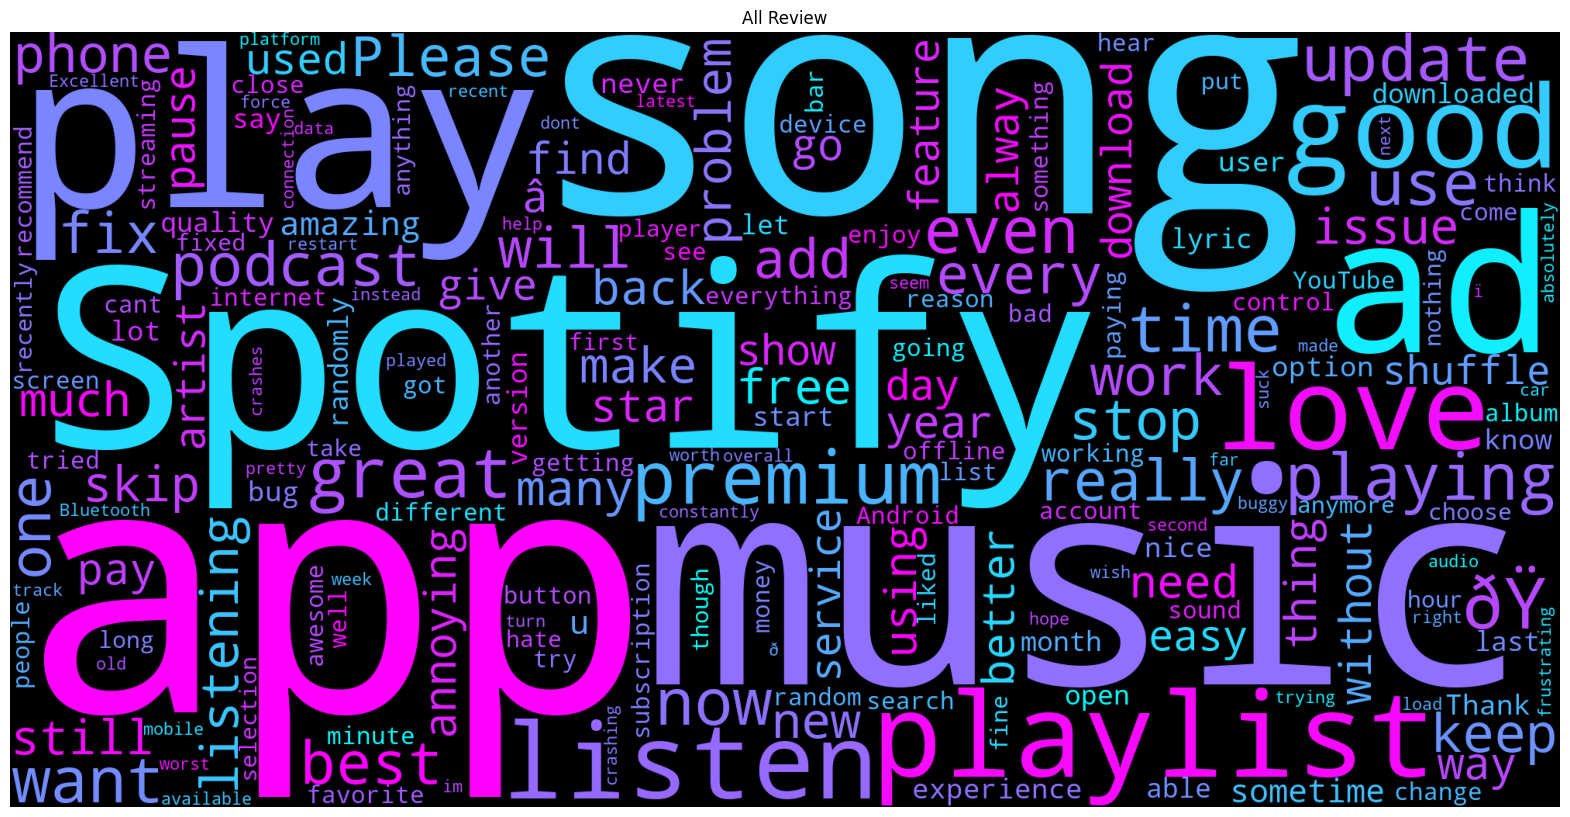

In [17]:
text_all = eda.Review.values
cloud_all = WordCloud(background_color='black', colormap='cool', collocations=False, width=2000, height=1000).generate(' '.join(text_all))

plt.figure(figsize=(20, 15))
plt.axis('off')
plt.title('All Review')
plt.imshow(cloud_all)

Berdasarkan informasi diatas, persebaran kata yang muncul masih bersifat general tanpa memerhatikan klasifikasinya. Tetapi, terdapat kata-kata yang berupa simbol dan beberapa *typo*.

### Positive

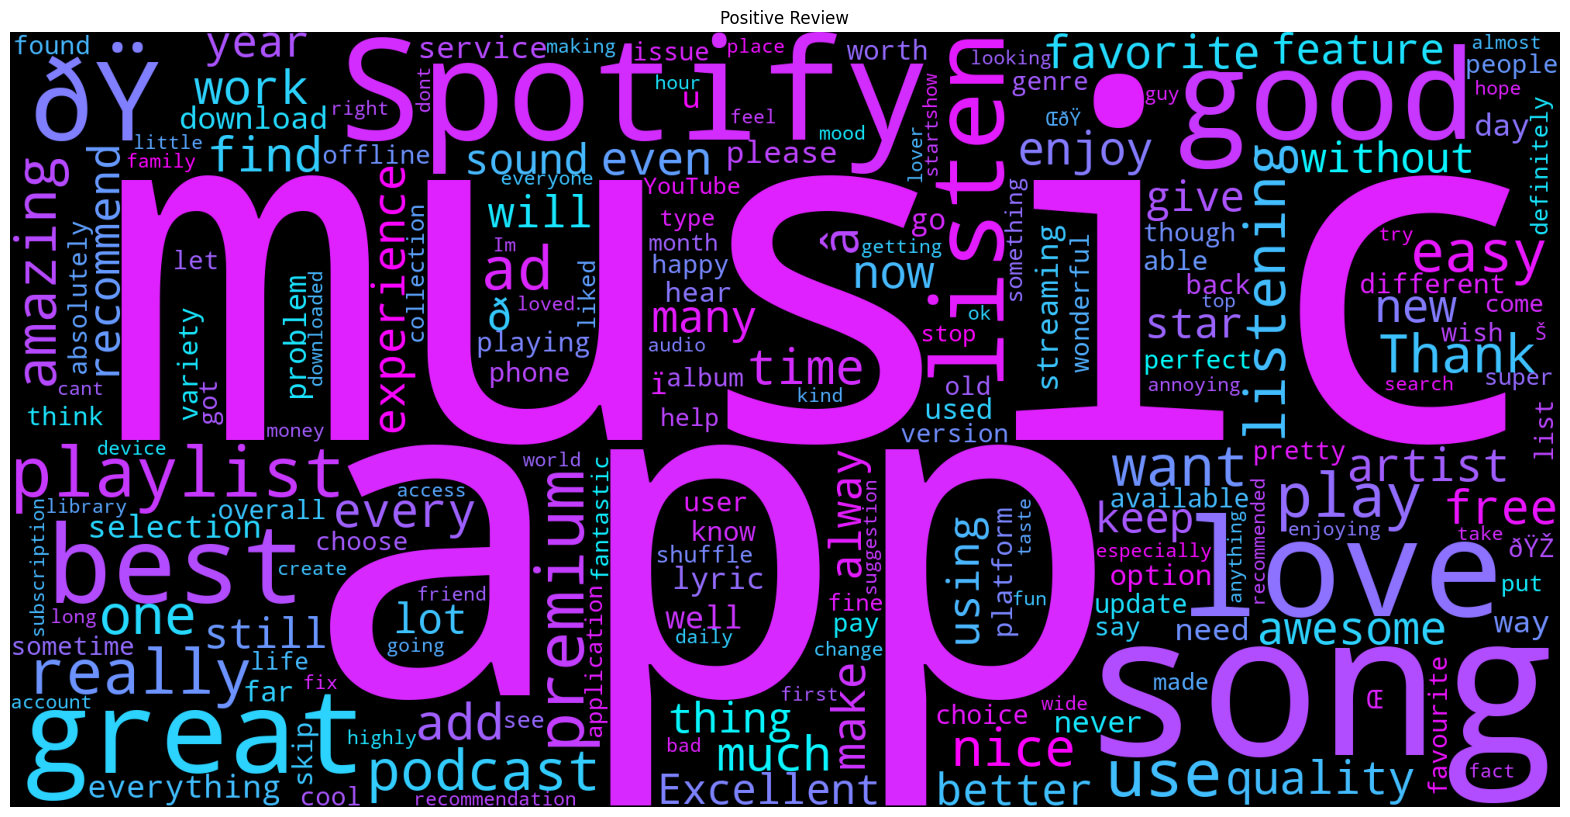

In [18]:
text_positive = eda[eda['label'] == 'POSITIVE'].Review.values
cloud_positive = WordCloud(background_color='black', colormap='cool', collocations=False, width=2000, height=1000).generate(' '.join(text_positive))

plt.figure(figsize=(20,15))
plt.axis('off')
plt.title('Positive Review')
plt.imshow(cloud_positive)

Berdasarkan informasi diatas, ada cukup banyak dan mencolok beberapa kata yang dalam bentuk simbol dan kata yang muncul dalam sekitar 2 atau 1 huruf. Hal-hal seperti ini harus dibersihkan untuk meningkatkan performa dalam **Modeling**.

### Negative

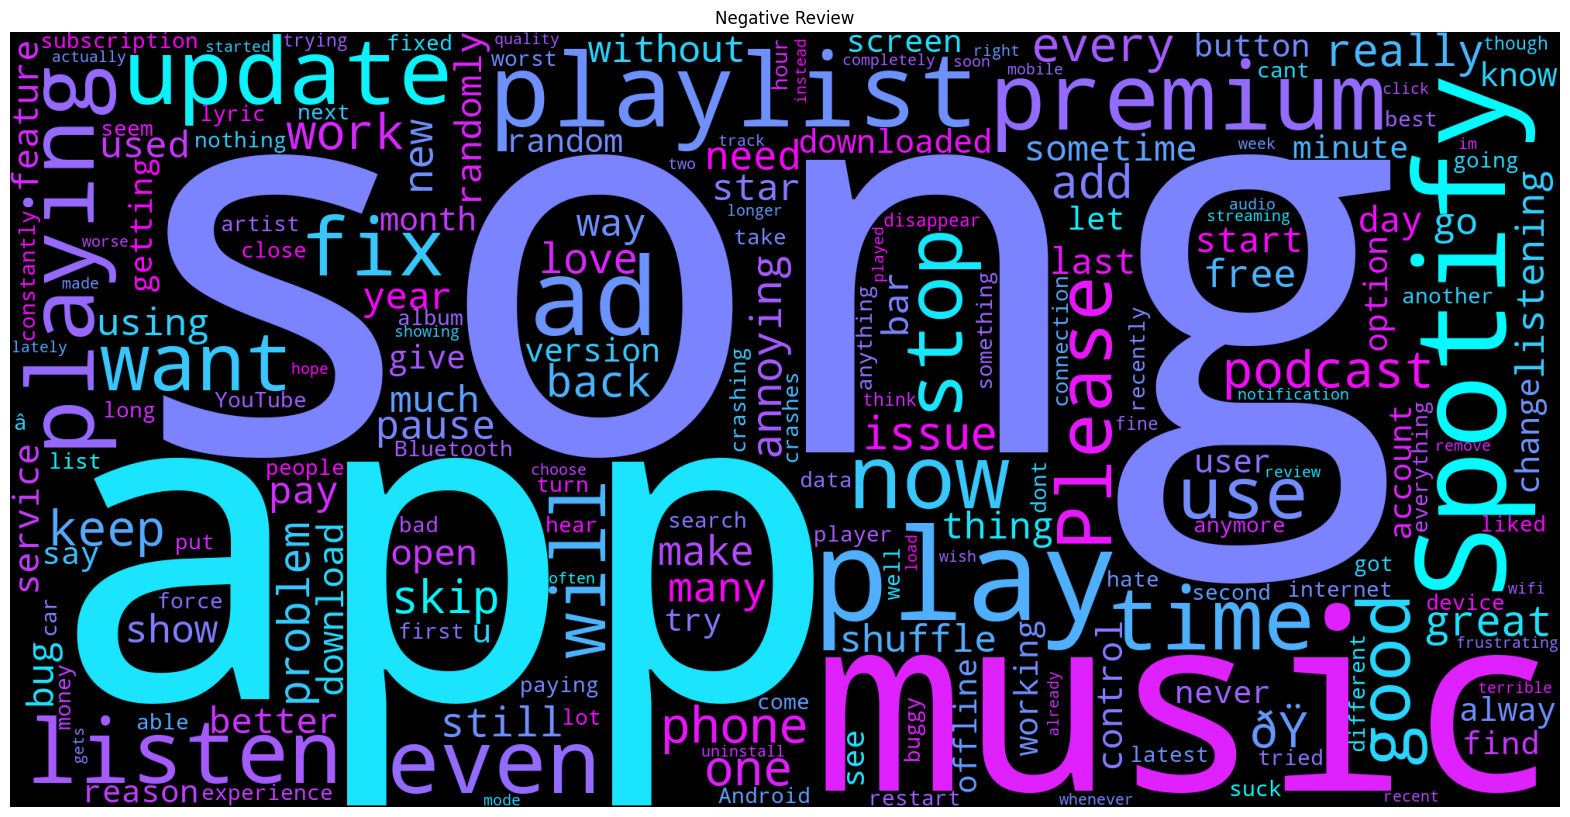

In [19]:
text_negative = eda[eda['label'] == 'NEGATIVE'].Review.values
cloud_negative = WordCloud(background_color='black', colormap='cool', collocations=False, width=2000, height=1000).generate(' '.join(text_negative))

plt.figure(figsize=(20,15))
plt.axis('off')
plt.title('Negative Review')
plt.imshow(cloud_negative)

Berdasarkan informasi diatas, ada cukup banyak dan mencolok beberapa kata yang dalam bentuk simbol dan kata yang muncul dalam sekitar 2 atau 1 huruf. Hal-hal seperti ini harus dibersihkan untuk meningkatkan performa dalam **Modeling**.

# Feature Engineering

## Text Preprocessing

Berdasarkan EDA yang telah dilakukan, terdapat beberapa tindakan yang dapat dilakukan untuk membersihkan teks sehingga dapat meningkatkan performa dalam **Modeling**, yaitu
- *Case folding*: membuat semua kata dalam kondisi *lower* agar mudah di analisis. Jika terdapat perbedaan *Case folding* dana kata tersebut sama, maka akan dianggap 2 kata yang berbeda oleh mesin.
- *Mention removal*: menghapus simbol @ yang biasa digunakan dalam memanggil suatu akun.
- *Hashtags removal*: menghapus # yang biasa digunakan sebagai keyword dalam suatu narasi kalimat.
- *Newline removal (\n)*: menghapus kondisi baris yang terdapat *Newline* yang mengakibatkan mesin tidak dapat bekerja secara efisien dalam menganalisis.
- *Under 3 char removal*: menghapus kata yang dibawah 3 char/huruf.
- *Whitespace removal*: menghapus suatu baris yang memiliki *space* yang besar.
- *URL removal*: menghapus suatu baris yang yang mencantumkan link website.
- *Non-letter removal*: menghapus karakter yang berupa simbol seperti yang tadi sempat muncul secara jelas ketika EDA.

In [20]:
# beberapa contoh kata aneh yang muncul dalam EDA diatas yang akan ditambahkan ke list stopword
additional = ["â", "u", "Im", "alway", "im", "ve", "WO", "re", "ll", "n't", "ad", 'hav']

In [21]:
# Define Stopwords
stpwds_en = list(set(stopwords.words('english')))
for i in additional:
    stpwds_en.append(i)

# Create WordNetLemmatizer object
lemmatizer = WordNetLemmatizer()

In [ ]:
# Create A Function for Text Preprocessing

def text_preprocessing(text):
    # Case folding
    text = text.lower()

    # Mention removal
    text = re.sub("@[A-Za-z0-9_]+", " ", text)

    # Hashtags removal
    text = re.sub("#[A-Za-z0-9_]+", " ", text)

    # Newline removal (\n)
    text = re.sub(r"\\n", " ",text)
    
    # Under 3 char removal
    text = re.sub(r"\b\w{1,2}\b", " ", text)

    # Whitespace removal
    text = text.strip()

    # URL removal
    text = re.sub(r"http\S+", " ", text)
    text = re.sub(r"www.\S+", " ", text)

    # Non-letter removal (such as emoticon, symbol (like μ, $, 兀), etc
    text = re.sub("[^A-Za-z\s']", " ", text)

    # Tokenization
    tokens = word_tokenize(text)

    # Stopwords removal
    tokens = [word for word in tokens if word not in stpwds_en]

    # Lemmatizing
    tokens = [lemmatizer.lemmatize(word, text, pos='v') for word in tokens]

    # Combining Tokens
    text = ' '.join(tokens)

    return text

In [23]:
# Applying Text Preprocessing to the Dataset

df['text_processed'] = df['Review'].apply(lambda x: text_preprocessing(x))
df

Review     label  \
0      Great music service, the audio is high quality...  POSITIVE   
1      Please ignore previous negative rating. This a...  POSITIVE   
2      This pop-up "Get the best Spotify experience o...  NEGATIVE   
3        Really buggy and terrible to use as of recently  NEGATIVE   
4      Dear Spotify why do I get songs that I didn't ...  NEGATIVE   
...                                                  ...       ...   
52697                                       Yes the best  POSITIVE   
52698  Spotify won my heart in Feb 2024 You won my he...  POSITIVE   
52699  I tried to open the app and it wont open I res...  POSITIVE   
52700                                              Good   POSITIVE   
52701  Nice app to play music and at very affordable ...  POSITIVE   

                                          text_processed  
0      great music service audio high quality app eas...  
1      please ignore previous negative rating app sup...  
2      pop get best spotify experience android annoyi...  
3                     really buggy terrible use recently  
4      dear spotify get song ' put playlist shuffle play  
...                                                  ...  
52697                                           yes best  
52698  spotify heart feb heart music lyric language e...  
52699  tried open app wont open restarted phone ill t...  
52700                                               good  
52701               nice app play music affordable price  

[52686 rows x 3 columns]

## Label Encoding

In [24]:
# Display Target

df.label.unique()

array(['POSITIVE', 'NEGATIVE'], dtype=object)

In [25]:
# Change Target into Number

df['target'] = df['label'].replace({'NEGATIVE' : 0, 'POSITIVE' : 1})

C:\Users\Rontlond\AppData\Local\Temp\ipykernel_6692\1574427201.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['target'] = df['label'].replace({'NEGATIVE' : 0, 'POSITIVE' : 1})


## Data Splitting

In [26]:
# Data Splitting

X_train_val, X_test, y_train_val, y_test = train_test_split(df.text_processed,
                                                    df.target,
                                                    test_size=0.15,
                                                    random_state=20,
                                                    stratify=df.target)

X_train, X_val, y_train, y_val = train_test_split(X_train_val,
                                                  y_train_val,
                                                  test_size=0.10,
                                                  random_state=20,
                                                  stratify=y_train_val)

print('Train Size : ', X_train.shape)
print('Val Size   : ', X_val.shape)
print('Test Size  : ', X_test.shape)

Train Size :  (40304,)
Val Size   :  (4479,)
Test Size  :  (7903,)


## Text Vectorization

> Text Vectorization dapat dikatakan sebagai standarisasi. Tujuannya untuk mengubah data berbentuk text menjadi numerik sehingga dapat dibaca oleh model ketika di train hingga di test.

In [27]:
# Get Vocabularies

Vectorize = CountVectorizer()
X_train_vec = Vectorize.fit_transform(X_train)
X_val_vec = Vectorize.transform(X_val)
X_test_vec = Vectorize.transform(X_test)

In [28]:
# Finding the Number of Vocabs and Max Token Length in One Document

total_vocab = len(Vectorize.vocabulary_.keys())
max_sen_len = max([len(i.split(" ")) for i in X_train])

# hasil dibawah ini akan digunakan dalam vektorisasi teks
print('Total Vocab : ', total_vocab)
print('Maximum Sentence Length : ', max_sen_len, 'tokens')

Total Vocab :  16189
Maximum Sentence Length :  106 tokens


In [ ]:
# Text Vectorization

text_vectorization = TextVectorization(max_tokens=total_vocab, # menggunakan hasil total_vocab
                                       standardize="lower_and_strip_punctuation",
                                       split="whitespace",
                                       ngrams=None,
                                       output_mode="int",
                                       output_sequence_length=max_sen_len, # menggunakan hasil max_sen_len
                                       input_shape=(1,)) # Only use in Sequential API

text_vectorization.adapt(X_train)

In [30]:
# Transform the data
X_train_vec = text_vectorization(X_train)
X_val_vec = text_vectorization(X_val)
X_test_vec = text_vectorization(X_test)

# Convert to numpy arrays
X_train_vec = X_train_vec.numpy()
X_val_vec = X_val_vec.numpy()
X_test_vec = X_test_vec.numpy()

X_train_vec

array([[  14,   49,   11, ...,    0,    0,    0],
       [   5, 2746, 1661, ...,    0,    0,    0],
       [   2,   31,  187, ...,    0,    0,    0],
       ...,
       [  10,   40,   22, ...,    0,    0,    0],
       [ 103,    4,    2, ...,    0,    0,    0],
       [   9,   33,   45, ...,    0,    0,    0]], dtype=int64)

# Exploratory Data Analysis (After Feature Engineering)

> Proses ini bertujuan untuk melihat hasil **Preprocessing** pada teks, sehingga dapat diketahui perbedaan dengan EDA sebelum **Preprocessing**.

Berdasarkan informasi yang ditampilkan dibawah ini, secara garis besar data sudah dalam kondisi bersih, baik itu sentimen secara general, positif, dan negatif, terutama dalam mengatasi beberapa hal berikut:
- Menghapus kata-kata yang memiliki huruf dibawah 3.
- Menghapus kata-kata yang berupa simbol.
- Menghapus kata-kata yang mengandung *typo*.

## Descriptive Statistics

### Data Distribution

In [31]:
edaaf = df.copy()

In [32]:
# check jumlah text tiap label
print(edaaf['label'].value_counts())

label
NEGATIVE    29423
POSITIVE    23263
Name: count, dtype: int64


C:\Users\Rontlond\AppData\Local\Temp\ipykernel_6692\3322630561.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=edaaf, palette='winter', ax=ax[0])


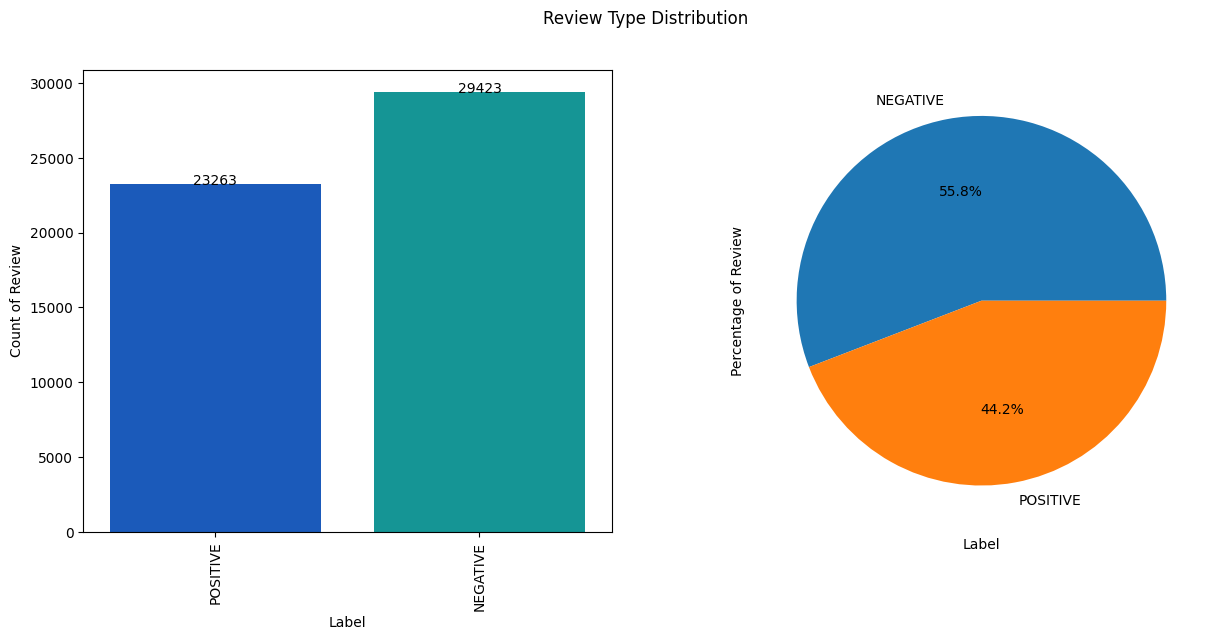

In [33]:
# Melihat secara garis besar persebaran data melalui visualisasi
fig, ax = plt.subplots(1,2,figsize=(15,6))

sns.countplot(x='label', data=edaaf, palette='winter', ax=ax[0])
ax[0].set_xlabel('Label')
ax[0].set_ylabel('Count of Review')
fig.suptitle('Review Type Distribution')
ax[0].tick_params(axis='x', rotation=90)
plt.xlabel('Label')
plt.ylabel('Count of Review')

for pch in ax[0].patches:
    ax[0].annotate('%.0f'%(pch.get_height()), (pch.get_x() + pch.get_width() / 2, pch.get_height()+205), ha='center', va='center')

edaaf['label'].value_counts().plot(kind='pie', autopct='%1.1f%%')
ax[1].set_ylabel('Percentage of Review')
plt.show()

### Sentence Analysis

In [34]:
edaaf['len_sentence'] = edaaf['text_processed'].apply(lambda x: len(nltk.sent_tokenize(x)))
print(f'Max kalimat pada review: {edaaf.len_sentence.max()}')
print(f'Mean kalimat pada review: {edaaf.len_sentence.mean()}')

Max kalimat pada review: 1
Mean kalimat pada review: 0.998937099039593


In [35]:
rate11 = edaaf.label.unique()

for i in rate11:
    print(f'Label: {i}')
    print(f'Max kalimat pada tiap label: {edaaf[edaaf.label == i].len_sentence.max()}')
    print(f'Mean kalimat pada tiap label: {edaaf[edaaf.label == i].len_sentence.mean()}')
    print('-'*20)

Label: POSITIVE
Max kalimat pada tiap label: 1
Mean kalimat pada tiap label: 0.9976357305592571
--------------------
Label: NEGATIVE
Max kalimat pada tiap label: 1
Mean kalimat pada tiap label: 0.9999660129830404
--------------------


Berdasarkan informasi diatas, maksimal dan rata-rata kalimat sudah tereduksi menjadi sekitar 1 saja di tiap *label*, padahal sebelum **Preprocessing** rata-rata kalimat yaitu 2.

### Word Analysis

In [36]:
edaaf['len_word'] = edaaf['text_processed'].apply(lambda x: len(nltk.word_tokenize(x)))
print(f'Max kata pada review: {edaaf.len_word.max()}')
print(f'Mean kata pada review: {edaaf.len_word.mean()}')

Max kata pada review: 154
Mean kata pada review: 14.991971301674068


In [37]:
rate22 = edaaf.label.unique()

for i in rate22:
    print(f'Label: {i}')
    print(f'Max kata pada tiap label: {edaaf[edaaf.label == i].len_word.max()}')
    print(f'Mean kata pada tiap label: {edaaf[edaaf.label == i].len_word.mean()}')
    print('-'*20)

Label: POSITIVE
Max kata pada tiap label: 102
Mean kata pada tiap label: 10.175385805786012
--------------------
Label: NEGATIVE
Max kata pada tiap label: 154
Mean kata pada tiap label: 18.800156340278015
--------------------


Berdasarkan informasi diatas, terdapat berbagai kata yang sudah tereduksi tiap baris teksnya hingga maksimal kata dalam suatu teks pada data yang menurun drastis.
- Pada *label* positif rata-ratanya yaitu 10 kata
- Pada *label* negatif rata-ratanya yaitu 19 kata

## Wordcloud

### General

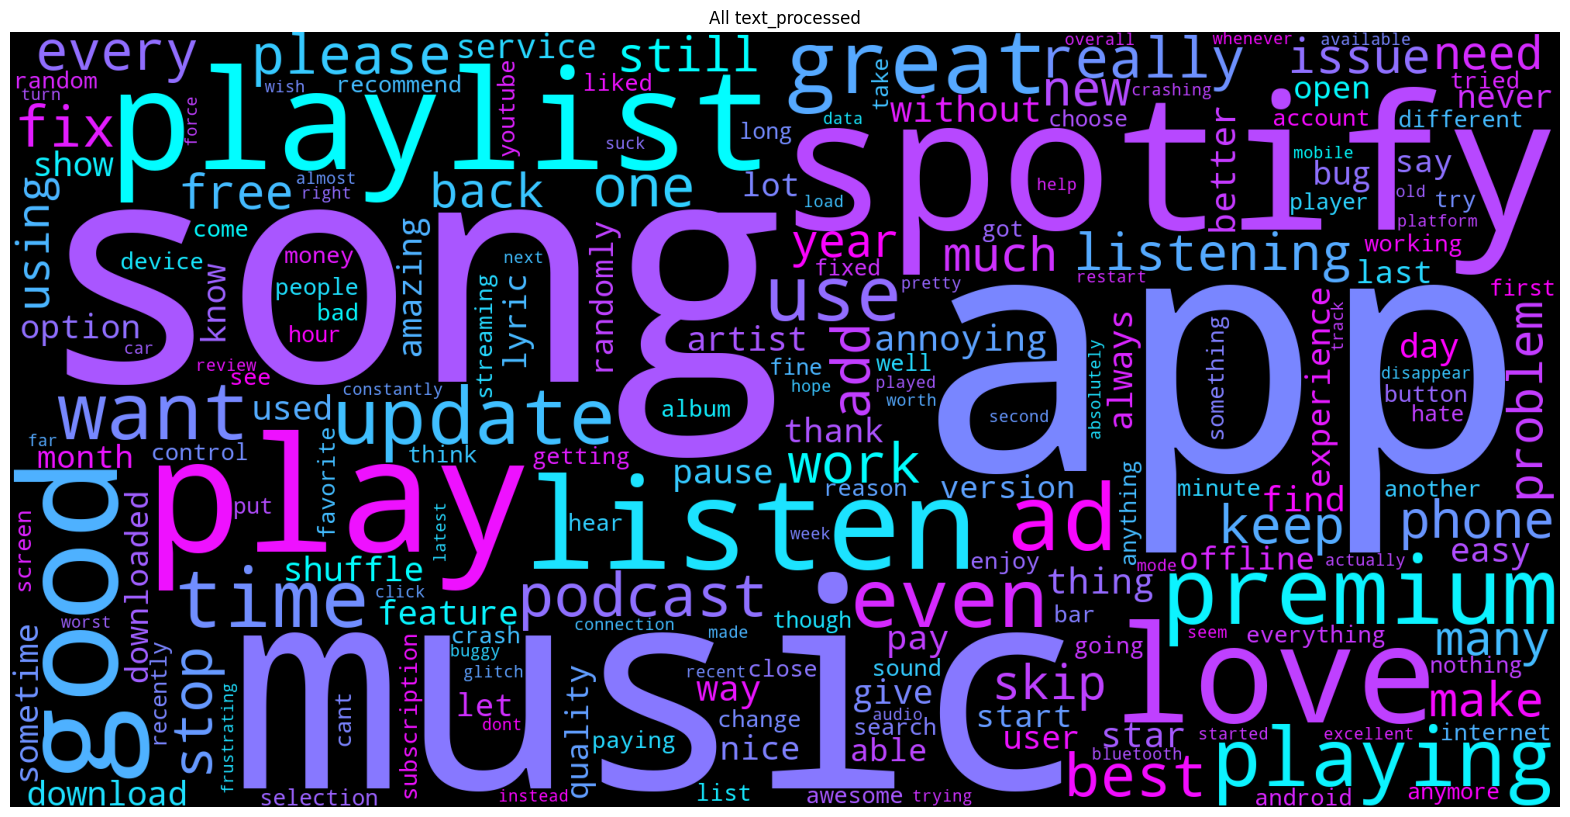

In [38]:
text_final = edaaf.text_processed.values
cloud_final = WordCloud(background_color='black', colormap='cool', collocations=False, width=2000, height=1000).generate(' '.join(text_final))

plt.figure(figsize=(20, 15))
plt.axis('off')
plt.title('All text_processed')
plt.imshow(cloud_final)

### Positive

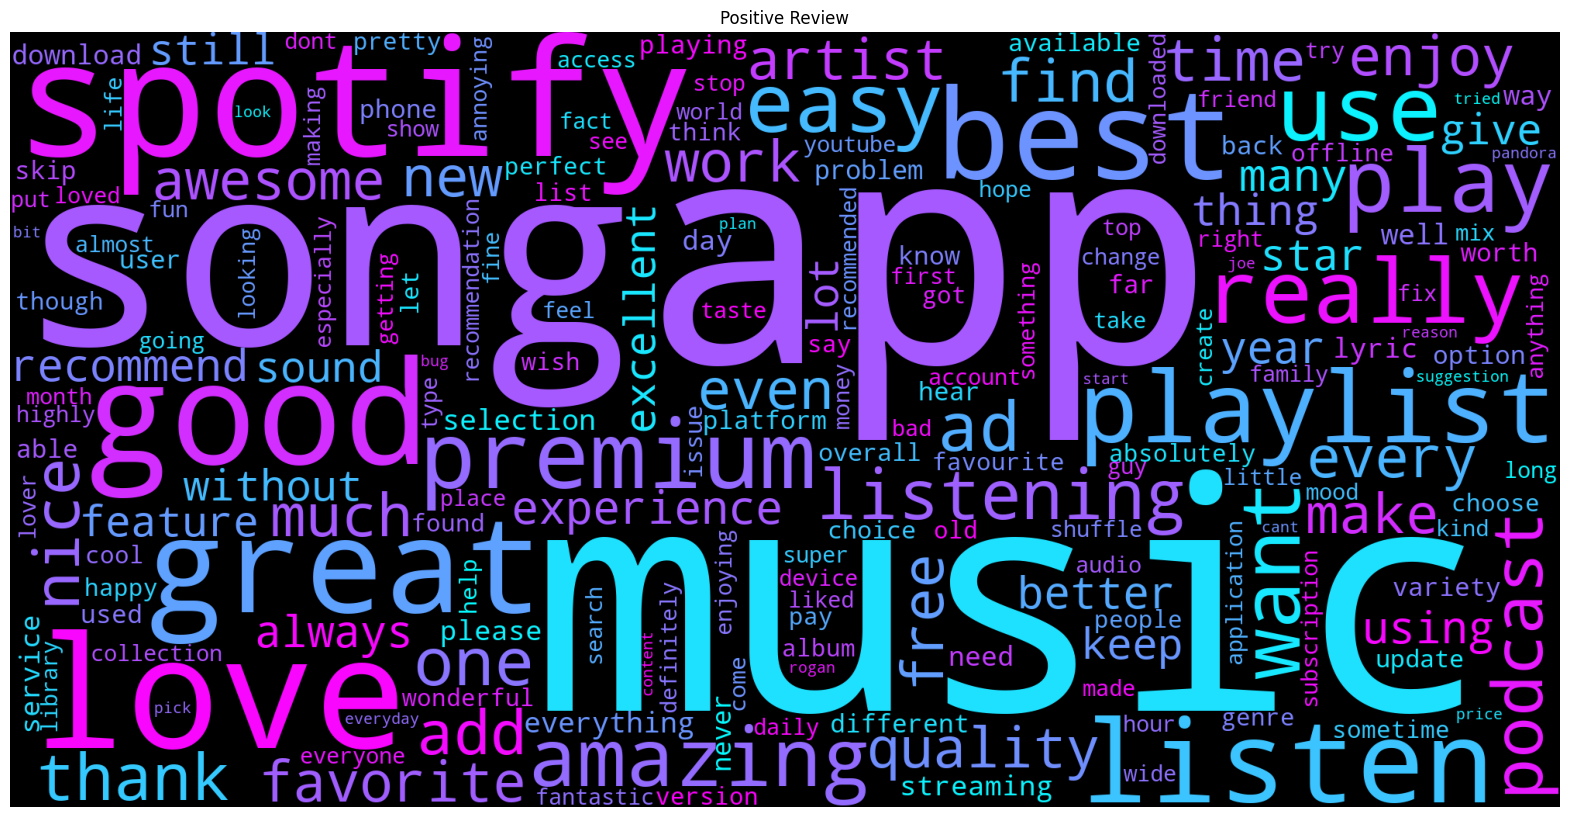

In [39]:
text_positive_final = edaaf[edaaf['label'] == 'POSITIVE'].text_processed.values
cloud_positive_final = WordCloud(background_color='black', colormap='cool', collocations=False, width=2000, height=1000).generate(' '.join(text_positive_final))

plt.figure(figsize=(20,15))
plt.axis('off')
plt.title('Positive Review')
plt.imshow(cloud_positive_final)

### Negative

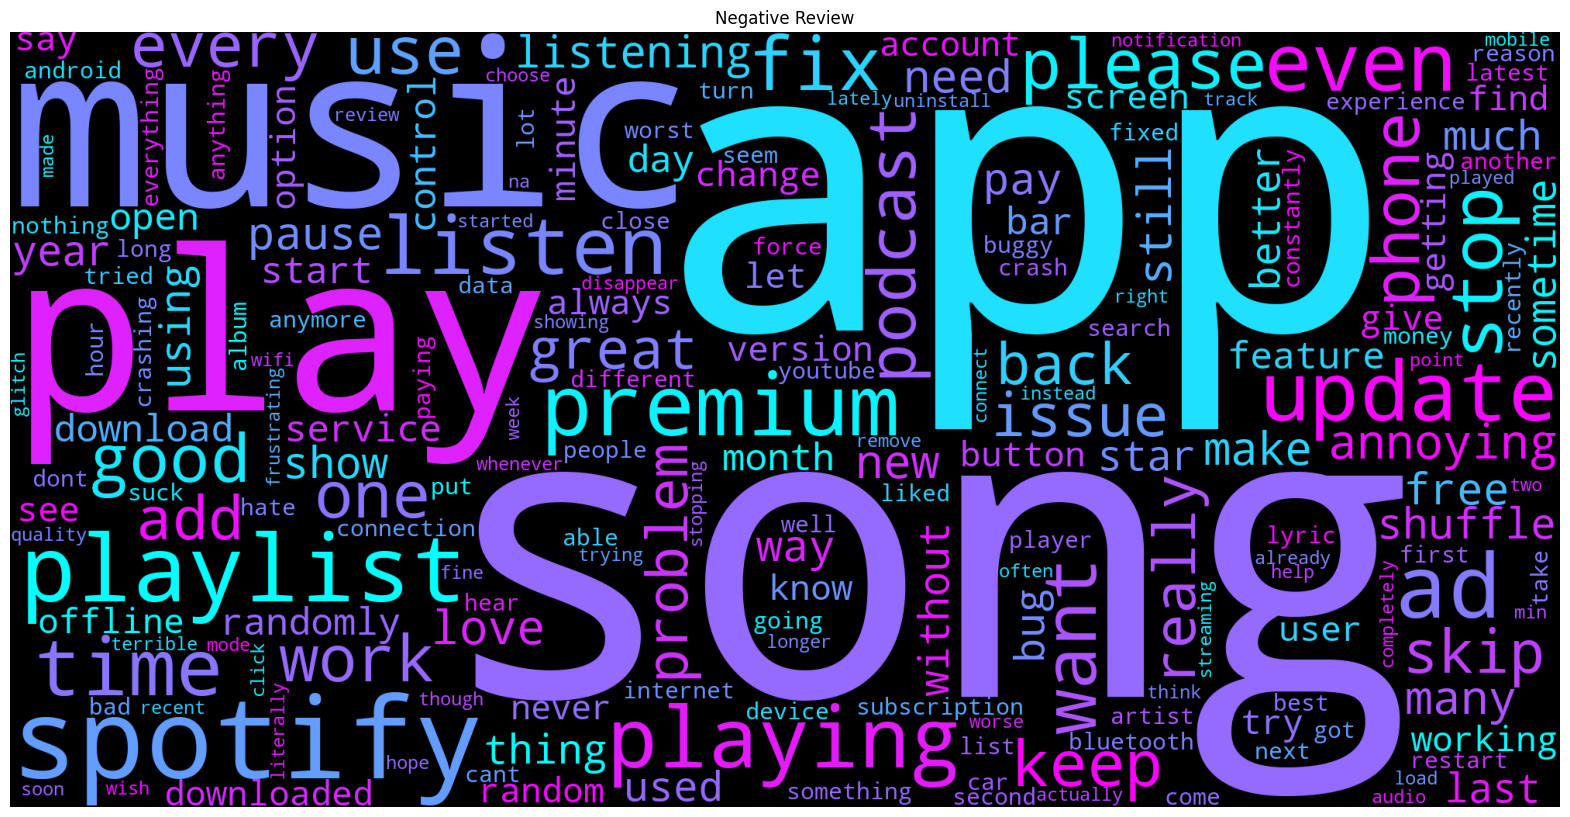

In [40]:
text_negative_final = edaaf[edaaf['label'] == 'NEGATIVE'].text_processed.values
cloud_negative_final = WordCloud(background_color='black', colormap='cool', collocations=False, width=2000, height=1000).generate(' '.join(text_negative_final))

plt.figure(figsize=(20,15))
plt.axis('off')
plt.title('Negative Review')
plt.imshow(cloud_negative_final)

**Rekomendasi Berdasarkan Kata Kunci Sentimen Negatif**  
Berdasarkan kondisi yang mengacu pada kata kunci *app, song, music, play* dan beberapa persebaran kata pada sentimen negatif, diharapkan pihak Spotify dapat fokus pada beberapa pengembangan berikut, yaitu:
- permasalahan saat menyetel musik, 
- sistem di playlist musik bermasalah, 
- ketidakpuasan pada pelayanan premium sehingga muncul pada sentimen negatif, 
- adanya bug di aplikasi Spotify berdasarkan kata kunci yang muncul,
- permasalahan akun Spotify.

# ANN Training

## Model Definition

In [41]:
# Clear session

seed = 47
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

**Clear session** dibuat untuk meminimalisir adanya perubahan *weight* tiap kali di *running*, dapat dikatakan sebagai *random state*.

In [42]:
# Create Sequential API

model_sequential = Sequential()
model_sequential.add(Dense(24,
                           activation='relu', # merupakan aktivasi yang paling efisien
                           kernel_initializer=tf.keras.initializers.HeNormal(seed),
                           input_shape=(106,)))
model_sequential.add(Dense(12,
                           activation='relu', # merupakan aktivasi yang paling efisien
                           kernel_initializer=tf.keras.initializers.HeNormal(seed)))
model_sequential.add(Dense(1,
                           activation='sigmoid', # merupakan aktivasi untuk output dengan data bersifat klasifiasi berbentuk binary
                           kernel_initializer=tf.keras.initializers.GlorotNormal(seed)))

model_sequential.compile(loss='binary_crossentropy', # karena hanya memiliki 1 output dan aktivasinya sigmoid, maka menggunakan binary_crossentropy
                         optimizer='adam',
                         metrics=['accuracy'])
model_sequential.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 24)                2568      
                                                                 
 dense_1 (Dense)             (None, 12)                300       
                                                                 
 dense_2 (Dense)             (None, 1)                 13        
                                                                 
Total params: 2,881
Trainable params: 2,881
Non-trainable params: 0
_________________________________________________________________


## Model Train

In [43]:
# Train the model

history_sequential = model_sequential.fit(X_train_vec,
                                          y_train,
                                          epochs=100,
                                          validation_data=(X_val_vec, y_val),
                                          batch_size=50)

Epoch 1/100
807/807 [==============================] - 6s 7ms/step - loss: 28.1888 - accuracy: 0.5905 - val_loss: 6.2416 - val_accuracy: 0.5961
Epoch 2/100
807/807 [==============================] - 5s 6ms/step - loss: 2.4847 - accuracy: 0.5889 - val_loss: 1.1936 - val_accuracy: 0.4718
Epoch 3/100
807/807 [==============================] - 5s 6ms/step - loss: 0.9050 - accuracy: 0.6154 - val_loss: 1.0496 - val_accuracy: 0.5814
Epoch 4/100
807/807 [==============================] - 5s 6ms/step - loss: 0.7453 - accuracy: 0.5891 - val_loss: 0.9851 - val_accuracy: 0.5001
Epoch 5/100
807/807 [==============================] - 6s 7ms/step - loss: 0.7050 - accuracy: 0.5948 - val_loss: 0.8778 - val_accuracy: 0.5863
Epoch 6/100
807/807 [==============================] - 8s 10ms/step - loss: 0.6893 - accuracy: 0.5828 - val_loss: 0.8448 - val_accuracy: 0.6021
Epoch 7/100
807/807 [==============================] - 6s 7ms/step - loss: 0.6964 - accuracy: 0.5852 - val_loss: 0.7976 - val_accuracy: 0.60

## Model Evaluation

Text(0.5, 1.0, 'Grafik Acc vs Val-Acc')

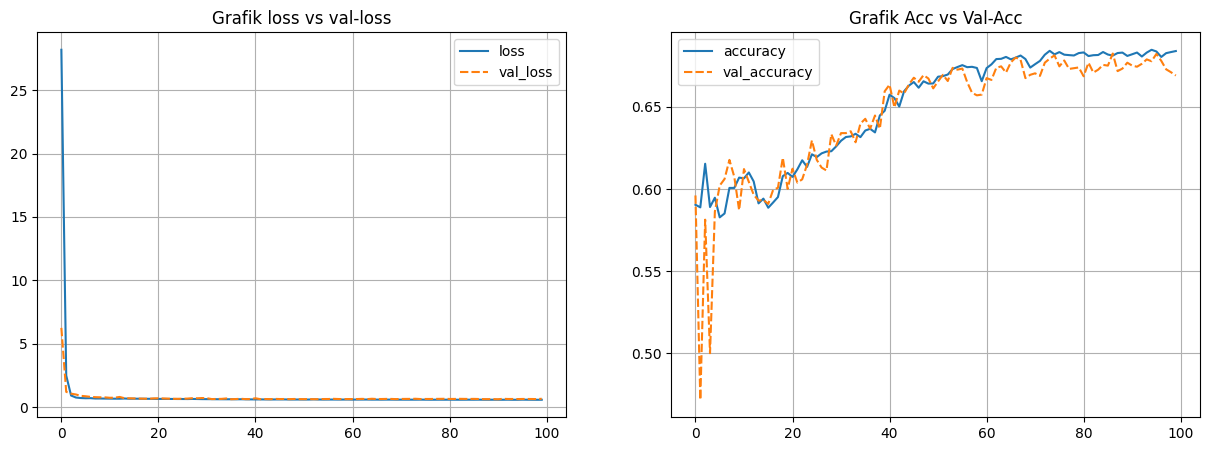

In [44]:
# Plot training result

history_sequential_df = pd.DataFrame(history_sequential.history)

plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
sns.lineplot(data=history_sequential_df[['loss', 'val_loss']])
plt.grid()
plt.title('Grafik loss vs val-loss')

plt.subplot(1, 2, 2)
sns.lineplot(data=history_sequential_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Grafik Acc vs Val-Acc')

In [45]:
# Predict test-set

y_pred_test = model_sequential.predict(X_test_vec)

247/247 [==============================] - 0s 2ms/step


In [46]:
# Model evaluation

y_pred_cls = np.where(y_pred_test >= 0.5, 1, 0)
print(classification_report(y_test, y_pred_cls))

              precision    recall  f1-score   support

           0       0.74      0.61      0.67      4414
           1       0.60      0.73      0.66      3489

    accuracy                           0.66      7903
   macro avg       0.67      0.67      0.66      7903
weighted avg       0.68      0.66      0.67      7903



Berdasarkan hasil evaluasi, terdapat beberapa informasi yang diketahui, yaitu:

**Kelemahan**
- Melihat hasil *precision, recall, f1-score* diketahui mampu memprediksi sentimen negatif dan positif dengan cukup baik, walaupun hasil evaluasi mereka menyatakan cenderung *underfit* berdasarkan berbagai pendapat para ilmuwan. *Precision* menyatakan model cenderung mampu memprediksi dengan baik pada sentimen negatif (0), sedangkan *recall* sebaliknya.
- Akurasi sebagai penunjang untuk evaluasi secara general menyatakan bahwa model cenderung *underfit* dengan nilai 66% atau 0.66.
- Dengan kondisi yang cenderung *underfit*, model mampu *train* data selama sekitar 8 menit atau cukup lama.

**Kelebihan**  
- Berdasarkan informasi yang dijelaskan pada metrik *f1-score*, diketahui model mampu memprediksi kedua sentimen dengan persentase cenderung seimbang.

**Rekomendasi**  
- Sangat disarankan untuk melakukan optimalisasi parameter (dropout, transfer learning, atau tuning manual parameter) atau mengganti model jika memungkinkan.

# ANN Improvement

## Model Definition

In [47]:
# Clear session

seed = 47
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

**Clear session** dibuat untuk meminimalisir adanya perubahan *weight* tiap kali di *running*, dapat dikatakan sebagai *random state*.

In [48]:
# Create Sequential API

model = Sequential()
model.add(Dense(24,
        activation='relu',
        kernel_initializer=tf.keras.initializers.HeNormal(seed),
        input_shape=(106,)))
model.add(Dense(12,
        activation='relu', 
        kernel_initializer=tf.keras.initializers.HeNormal(seed)))
model.add(Dense(1,
        activation='sigmoid', 
        kernel_initializer=tf.keras.initializers.GlorotNormal(seed)))

model.compile(loss='binary_crossentropy', 
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), # modifikasi learning rate
            metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 24)                2568      
                                                                 
 dense_1 (Dense)             (None, 12)                300       
                                                                 
 dense_2 (Dense)             (None, 1)                 13        
                                                                 
Total params: 2,881
Trainable params: 2,881
Non-trainable params: 0
_________________________________________________________________


## Model Train

In [49]:
# Train the model
history = model.fit(X_train_vec,
                    y_train,
                    epochs=100,
                    validation_data=(X_val_vec, y_val),
                    batch_size=50)

Epoch 1/100
807/807 [==============================] - 5s 6ms/step - loss: 43.8976 - accuracy: 0.5777 - val_loss: 17.0192 - val_accuracy: 0.5890
Epoch 2/100
807/807 [==============================] - 5s 6ms/step - loss: 13.3653 - accuracy: 0.6043 - val_loss: 8.9091 - val_accuracy: 0.6004
Epoch 3/100
807/807 [==============================] - 4s 5ms/step - loss: 6.0181 - accuracy: 0.6176 - val_loss: 3.2147 - val_accuracy: 0.6091
Epoch 4/100
807/807 [==============================] - 4s 6ms/step - loss: 1.9860 - accuracy: 0.5800 - val_loss: 1.6072 - val_accuracy: 0.5285
Epoch 5/100
807/807 [==============================] - 4s 5ms/step - loss: 1.0721 - accuracy: 0.6084 - val_loss: 1.0556 - val_accuracy: 0.6490
Epoch 6/100
807/807 [==============================] - 5s 6ms/step - loss: 0.7830 - accuracy: 0.6110 - val_loss: 0.9274 - val_accuracy: 0.6138
Epoch 7/100
807/807 [==============================] - 4s 5ms/step - loss: 0.7115 - accuracy: 0.5902 - val_loss: 0.9448 - val_accuracy: 0.6

## Model Evaluation

Text(0.5, 1.0, 'Grafik Acc vs Val-Acc')

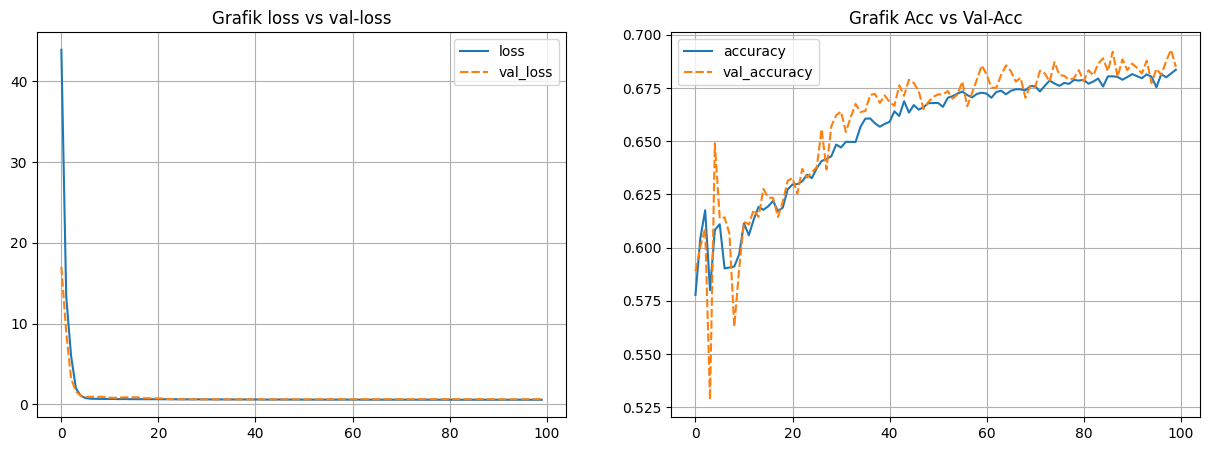

In [50]:
# Plot training result

history_df = pd.DataFrame(history.history)

plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
sns.lineplot(data=history_df[['loss', 'val_loss']])
plt.grid()
plt.title('Grafik loss vs val-loss')

plt.subplot(1, 2, 2)
sns.lineplot(data=history_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Grafik Acc vs Val-Acc')

In [51]:
# Predict test-set

y_pred_test_improve = model.predict(X_test_vec)

247/247 [==============================] - 0s 2ms/step


In [52]:
# Model evaluation

y_pred_cls_improve = np.where(y_pred_test_improve >= 0.5, 1, 0)
print(classification_report(y_test, y_pred_cls_improve))

              precision    recall  f1-score   support

           0       0.66      0.90      0.76      4414
           1       0.77      0.42      0.55      3489

    accuracy                           0.69      7903
   macro avg       0.72      0.66      0.65      7903
weighted avg       0.71      0.69      0.67      7903



Berdasarkan evaluasi yang telah dilakukan pada percobaan meningkatkan model, diketahui:

**Kelebihan**  
- Proses modeling lebih cepat yaitu menjadi sekitar 7 menit atau umumnya akan cenderung lebih cepat untuk memperoleh hasilnya.
- *Precision* menyatakan bahwa model cenderung mampu memprediksi sentimen dengan cukup seimbang.
- Akurasi yang dihasilkan cenderung meningkat menjadi 0.69 atau 69%.  

**Kelemahan**  
- *Recall dan f1-score* menyatakan bahwa model mampu memprediksi sentimen negatif (0), tetapi kurang dalam prediksi sentimen positif.  

**Rekomendasi**    
- Melakukan optimalisasi secara lebih mendalam atau menggunakan model yang berbeda untuk dapat mengetahui hasilnya dengan lebih jelas.

# Model Saving

In [53]:
model.trainable = False
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 24)                2568      
                                                                 
 dense_1 (Dense)             (None, 12)                300       
                                                                 
 dense_2 (Dense)             (None, 1)                 13        
                                                                 
Total params: 2,881
Trainable params: 0
Non-trainable params: 2,881
_________________________________________________________________


In [55]:
# save model
with open('model.pkl', 'wb') as file_1:
    pickle.dump(model, file_1)

model.save('Sportify_Sentiment.keras')

# save countVectorizer
with open('Vectorize.pkl', 'wb') as file_2:
    pickle.dump(Vectorize, file_2)

# Save TextVectorization yang mana harus dipisah dulu menurut: 'https://stackoverflow.com/questions/65103526/how-to-save-textvectorization-to-disk-in-tensorflow'
# Pickle the config and weights 
pickle.dump({'config': text_vectorization.get_config(),
             'weights': text_vectorization.get_weights()}
            , open("tv_layer.pkl", "wb"))

INFO:tensorflow:Assets written to: ram://5a869916-e193-4129-a206-da0e6b5d0ae2/assets


# Conclusion

Berdasarkan penelitian yang telah dilakukan, terdapat beberapa informasi yang dapat disampaikan yaitu:

### **Model**  
Secara garis besar, terdapat perbedaan pada model yang dimodifikasi dibandingkan ketika menggunakan *baseline model*. Meskipun begitu, model tersebut masih perlu ada pengembangan lebih lanjut jika menginginkan hasil yang diinginkan. Berikut ini penjabaran pada hasil peningkatan model:

- **Kelebihan**  
    - Proses modeling lebih cepat yaitu menjadi sekitar 7 menit atau umumnya akan cenderung lebih cepat untuk memperoleh hasilnya.
    - *Precision* menyatakan bahwa model cenderung mampu memprediksi sentimen dengan cukup seimbang.
    - Akurasi yang dihasilkan cenderung meningkat menjadi 0.69 atau 69%.  

- **Kelemahan**  
    - *Recall dan f1-score* menyatakan bahwa model mampu memprediksi sentimen negatif (0), tetapi kurang dalam prediksi sentimen positif.  

- **Rekomendasi**    
    - Melakukan optimalisasi secara lebih mendalam atau menggunakan model yang berbeda untuk dapat mengetahui hasilnya dengan lebih jelas.

### **Exploration Data Analysis**

Melalui banyaknya kosakata yang muncul pada kedua jenis sentimen, pada sektor negatif merupakan bagian penting untuk diketahui secara mendalam jika pihak Spotify ingin terus melangkah maju dalam mempertahankan produknya.

**Rekomendasi Berdasarkan Kata Kunci Sentimen Negatif**  
Berdasarkan kondisi yang mengacu pada kata kunci *app, song, music, play* dan beberapa persebaran kata pada sentimen negatif, diharapkan pihak Spotify dapat fokus pada beberapa pengembangan berikut, yaitu:
- Permasalahan saat menyetel musik, 
- Sistem di playlist musik bermasalah, 
- Mengatasi berbagai bug yang muncul di aplikasi,
- Ketidakpuasan pada pelayanan premium sehingga muncul pada sentimen negatif, 
- Permasalahan akun Spotify.